-  This notebook is to run active learning on current dataset and suggest next experimental plan

In [ ]:
# Add the src directory to sys.path
import sys
sys.path.append(os.path.abspath('../src'))

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from itertools import product
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import pandas as pd
import pickle

from Active_learning import *
from utils import *

In [2]:
df_input = pd.read_csv('df_combine_20240607.csv')
df_input['num_vesicles'] = df_input['num_vesicles'].round().astype(int)
df_input

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles,area_vesicles,area_percent
0,2.325,2.275,1.850,0.645,0.049,0.0465,0.260,46,14089.061304,0.013436
1,2.150,1.075,2.175,0.610,0.575,0.3150,0.177,34,26374.848424,0.025153
2,2.200,0.014,1.325,0.145,1.700,0.4875,0.440,27,18298.599110,0.017451
3,1.925,0.375,0.570,2.125,0.585,0.2625,0.058,4,1575.901415,0.001503
4,1.125,1.700,2.375,0.615,0.950,0.4575,0.063,32,13276.959603,0.012662
5,1.775,0.635,0.825,1.225,0.775,0.3825,0.200,80,30555.915547,0.029140
6,1.500,0.111,2.275,1.075,1.025,0.3975,0.445,66,27179.292493,0.025920
7,2.050,0.920,1.300,1.500,0.270,0.0300,0.175,12,5227.217476,0.004985
8,1.425,0.185,0.655,0.565,1.575,0.2505,0.007,65,43924.963084,0.041890
9,0.995,0.975,0.002,1.950,0.815,0.4950,0.240,194,86737.409670,0.082719


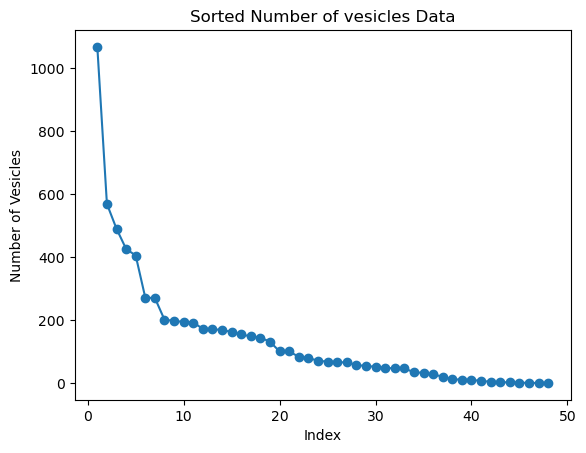

In [3]:
# Sort the DataFrame based on the "area_percent" column
df_sorted = df_input.sort_values(by="num_vesicles", ascending=False)

# Plot the sorted data
plt.plot(range(1, len(df_sorted) + 1), df_sorted["num_vesicles"], marker='o')
plt.xlabel("Index")
plt.ylabel("Number of Vesicles")
plt.title("Sorted Number of vesicles Data")
plt.show()

In [4]:
len(df_input[df_input['num_vesicles']>0])/48
# 92% have vesicles

0.9375

In [5]:
# Apply log1p transformation to each value in the DataFrame
df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))
df_input=df_input.iloc[:, 0:8]
df_input

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/2331498562.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,1.201470,1.186318,1.047319,0.497740,0.047837,0.045451,0.231112,46
1,1.147402,0.729961,1.155308,0.476234,0.454255,0.273837,0.162969,34
2,1.163151,0.013903,0.843720,0.135405,0.993252,0.397097,0.364643,27
3,1.073294,0.318454,0.451076,1.139434,0.460584,0.233094,0.056380,4
4,0.753772,0.993252,1.216395,0.479335,0.667829,0.376723,0.061095,32
5,1.020651,0.491643,0.601580,0.799757,0.573800,0.323893,0.182322,80
6,0.916291,0.105261,1.186318,0.729961,0.705570,0.334685,0.368109,66
7,1.115142,0.652325,0.832909,0.916291,0.239017,0.029559,0.161268,12
8,0.885832,0.169743,0.503801,0.447886,0.945850,0.223543,0.006976,65
9,0.690644,0.680568,0.001998,1.081805,0.596085,0.402126,0.215111,194


In [6]:
df_input.to_csv('../../data/20240606/df_input_20240607.csv', index=False)

In [2]:
df_input_init = pd.read_csv('../../data/20240531/df_input_update_20240601.csv')

In [10]:
df_input_update = pd.concat([df_input_init, df_input])
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
43,0.765468,0.551007,0.788457,0.235072,1.047319,0.533565,0.095310,83
44,1.081805,0.639219,0.620576,0.906240,0.385262,0.244905,0.094401,68
45,0.005982,0.864997,0.470004,0.672944,0.993252,0.247251,0.037296,490
46,0.542324,0.974560,0.565314,0.428530,0.875469,0.209045,0.246860,405


In [11]:
df_input_update.to_csv('../../data/20240606/df_input_update_20240607.csv', index = False)

In [3]:
df_input_update = pd.read_csv('../../data/20240606/df_input_update_20240607.csv')

In [4]:
# Input for classification model
df_input_update['num_vesicles'] = df_input_update['num_vesicles'].apply(lambda x: 0 if x < 1 else 1)
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,1
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,1
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,1
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,1
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,1
...,...,...,...,...,...,...,...,...
283,0.765468,0.551007,0.788457,0.235072,1.047319,0.533565,0.095310,1
284,1.081805,0.639219,0.620576,0.906240,0.385262,0.244905,0.094401,1
285,0.005982,0.864997,0.470004,0.672944,0.993252,0.247251,0.037296,1
286,0.542324,0.974560,0.565314,0.428530,0.875469,0.209045,0.246860,1


In [5]:
# data already done the log1p transform
X = df_input_update.iloc[:,0:7].values
y = df_input_update.iloc[:,-1:].values.ravel()

Iteration 1: Training Accuracy = 0.9087, Test Accuracy = 0.9483
Iteration 2: Training Accuracy = 0.9217, Test Accuracy = 0.8276
Iteration 3: Training Accuracy = 0.9565, Test Accuracy = 0.7931
Iteration 4: Training Accuracy = 0.9435, Test Accuracy = 0.8621
Iteration 5: Training Accuracy = 0.9696, Test Accuracy = 0.7586
Iteration 6: Training Accuracy = 0.9696, Test Accuracy = 0.8621
Iteration 7: Training Accuracy = 0.9565, Test Accuracy = 0.8276
Iteration 8: Training Accuracy = 0.9087, Test Accuracy = 0.8103
Iteration 9: Training Accuracy = 0.9391, Test Accuracy = 0.8103
Iteration 10: Training Accuracy = 0.9565, Test Accuracy = 0.7931

Average Training Accuracy over 10 runs: 0.9430
Average Test Accuracy over 10 runs: 0.8293


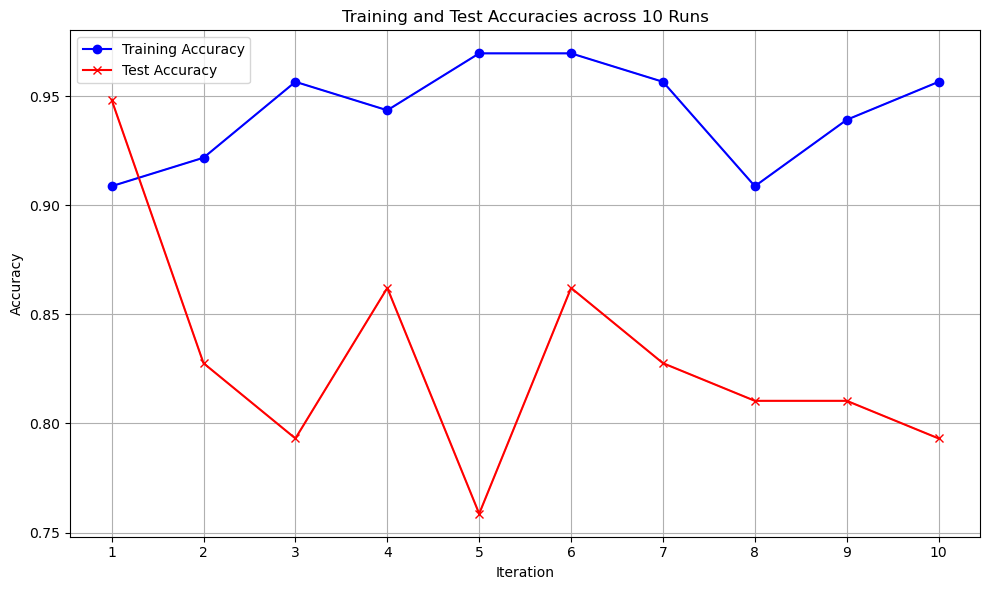

In [14]:

train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)

print(f"\nAverage Training Accuracy over 10 runs: {avg_train_accuracy:.4f}")
print(f"Average Test Accuracy over 10 runs: {avg_test_accuracy:.4f}")


# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the training accuracy
plt.plot(range(1, 11), train_accuracies, marker='o', color='blue', label='Training Accuracy')

# Plotting the test accuracy
plt.plot(range(1, 11), test_accuracies, marker='x', color='red', label='Test Accuracy')

# Connecting scatter points with lines
plt.plot(range(1, 11), train_accuracies, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.plot(range(1, 11), test_accuracies, color='red', linewidth=1, linestyle='-', alpha=0.5)

# Adding labels and title
plt.title('Training and Test Accuracies across 10 Runs')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Iteration 1: Training Accuracy = 0.9087, Test Accuracy = 0.9483
Iteration 2: Training Accuracy = 0.9217, Test Accuracy = 0.8276
Iteration 3: Training Accuracy = 0.9565, Test Accuracy = 0.7931
Iteration 4: Training Accuracy = 0.9435, Test Accuracy = 0.8621
Iteration 5: Training Accuracy = 0.9696, Test Accuracy = 0.7586
Iteration 6: Training Accuracy = 0.9696, Test Accuracy = 0.8621
Iteration 7: Training Accuracy = 0.9565, Test Accuracy = 0.8276
Iteration 8: Training Accuracy = 0.9087, Test Accuracy = 0.8103
Iteration 9: Training Accuracy = 0.9391, Test Accuracy = 0.8103
Iteration 10: Training Accuracy = 0.9565, Test Accuracy = 0.7931

Average Training Accuracy: 0.9430
Training Accuracy Standard Deviation: 0.0219
Average Test Accuracy: 0.8293
Test Accuracy Standard Deviation: 0.0496


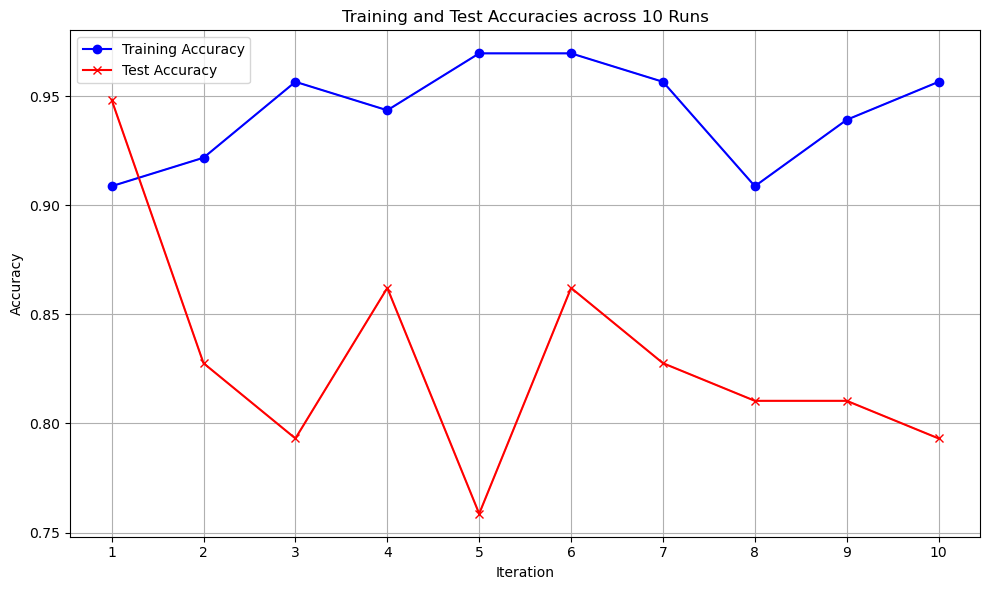

In [6]:
# Calculate std for repeated runs
train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Calculate the average and standard deviation of training and testing accuracies
average_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"\nAverage Training Accuracy: {average_train_accuracy:.4f}")
print(f"Training Accuracy Standard Deviation: {std_train_accuracy:.4f}")
print(f"Average Test Accuracy: {average_test_accuracy:.4f}")
print(f"Test Accuracy Standard Deviation: {std_test_accuracy:.4f}")


# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the training accuracy
plt.plot(range(1, 11), train_accuracies, marker='o', color='blue', label='Training Accuracy')

# Plotting the test accuracy
plt.plot(range(1, 11), test_accuracies, marker='x', color='red', label='Test Accuracy')

# Connecting scatter points with lines
plt.plot(range(1, 11), train_accuracies, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.plot(range(1, 11), test_accuracies, color='red', linewidth=1, linestyle='-', alpha=0.5)

# Adding labels and title
plt.title('Training and Test Accuracies across 10 Runs')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# working on whole dagtaset to get final model
kernel = 1.0 * RBF(1)
model = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X, y)

model.score(X, y)

0.9236111111111112

In [16]:
# Save the model to a file
with open('../../data/20240606/GPC_model_20240607.pkl', 'wb') as file:
    pickle.dump(model, file)

In [62]:
model.kernel_.get_params()

{'k1': 4.36**2,
 'k2': RBF(length_scale=1.08),
 'k1__constant_value': 19.042247957762708,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 1.0821779901990118,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/3588621919.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='group', y='sum', data=vesicles, palette='Set2', marker='o', size=8, edgecolor='black', linewidth=0.5, alpha=0.7)
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/3588621919.py:25: FutureWarning: Passing `palette` witho

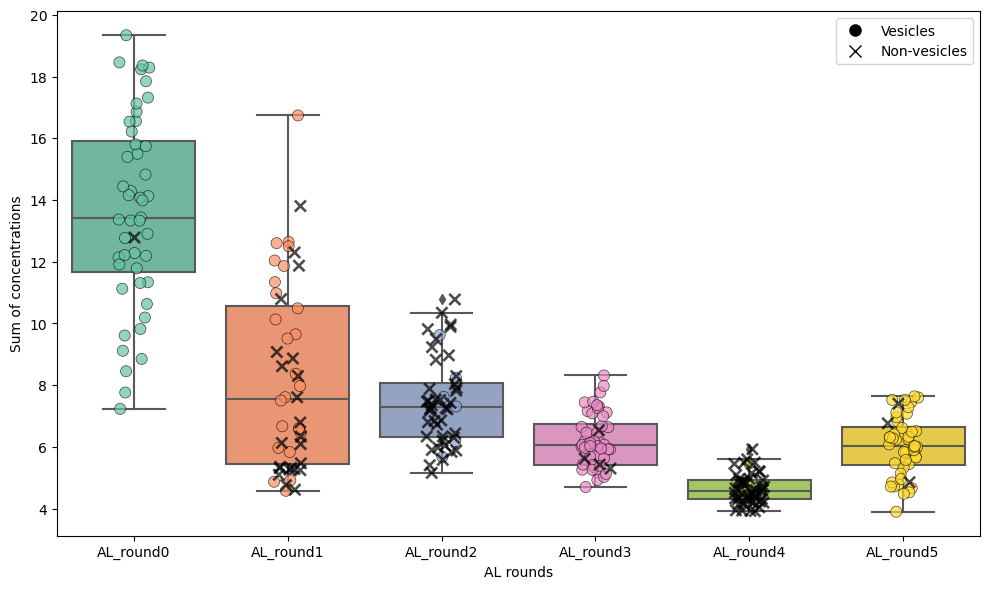

In [19]:
# See it on original scale
# Apply expm1 to the first 7 columns
df_input_update.iloc[:, :7] = df_input_update.iloc[:, :7].apply(np.expm1)

df_input_update['sum'] = df_input_update.iloc[:, :7].sum(axis=1)

# Split the DataFrame into 6 groups of 48 rows and add a 'group' column
group_labels = np.repeat([1, 2, 3, 4, 5, 6], 48)
df_input_update['group'] = group_labels[:len(df_input_update)]

# Separate data for vesicles and non-vesicles
vesicles = df_input_update[df_input_update['num_vesicles'] == 1]
non_vesicles = df_input_update[df_input_update['num_vesicles'] == 0]

# Initialize the figure
plt.figure(figsize=(10, 6))

# Create a box plot with Seaborn
sns.boxplot(x='group', y='sum', data=df_input_update, palette='Set2', width=0.8)

# Overlay a scatter plot for vesicles
sns.stripplot(x='group', y='sum', data=vesicles, palette='Set2', marker='o', size=8, edgecolor='black', linewidth=0.5, alpha=0.7)

# Overlay a scatter plot for non-vesicles
sns.stripplot(x='group', y='sum', data=non_vesicles, palette='Set2', marker='x', size=8, edgecolor='black', linewidth=1.9, alpha=0.7)

# Add labels and title
plt.xlabel('AL rounds')
plt.ylabel('Sum of concentrations')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['AL_round0', 'AL_round1', 'AL_round2', 'AL_round3', 'AL_round4', 'AL_round5'])

# Add custom legend
import matplotlib.lines as mlines

vesicles_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Vesicles')
non_vesicles_legend = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=8, label='Non-vesicles')

plt.legend(handles=[vesicles_legend, non_vesicles_legend])

# Show the plot
plt.tight_layout()
plt.show()

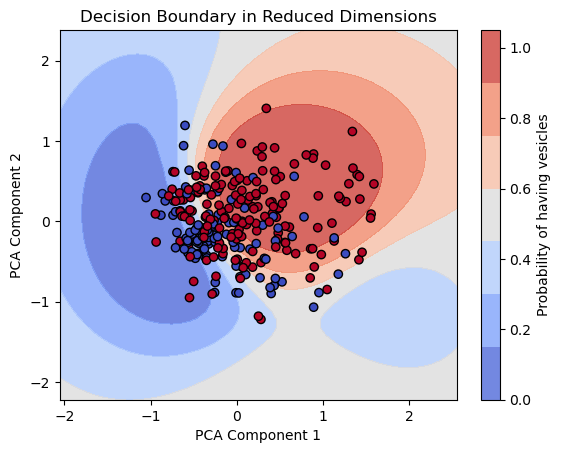

In [20]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
# Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
# Z = Z.reshape(xx.shape)
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_original_space = pca.inverse_transform(grid_points)
probs = model.predict_proba(grid_points_original_space)
probs_class_1 = probs[:, 1].reshape(xx.shape)

# Plot decision boundary and data points
contour = plt.contourf(xx, yy, probs_class_1, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary in Reduced Dimensions')
# Add color bar
cbar = plt.colorbar(contour)
cbar.set_label('Probability of having vesicles')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

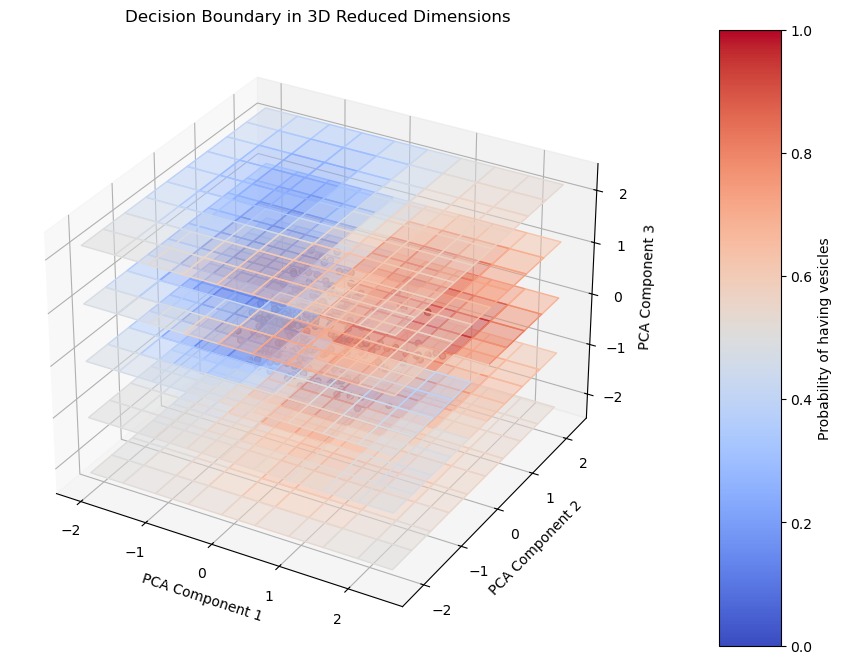

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize

# Assuming X and y are already defined
# Fit PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
z_min, z_max = X_reduced[:, 2].min() - 1, X_reduced[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))

# Create the figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot slices of the decision boundary at different z levels
z_levels = np.linspace(z_min, z_max, num=5)
norm = Normalize(vmin=0, vmax=1)

for z in z_levels:
    zz = np.full_like(xx, z)
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    grid_points_original_space = pca.inverse_transform(grid_points)
    probs = model.predict_proba(grid_points_original_space)
    probs_class_1 = probs[:, 1].reshape(xx.shape)
    
    # Plot the surface for this z slice
    surf = ax.plot_surface(xx, yy, zz, facecolors=plt.cm.coolwarm(norm(probs_class_1)), alpha=0.5, shade=False)
    
# Plot the data points
sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)

# Add labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Decision Boundary in 3D Reduced Dimensions')

# Add color bar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, aspect=10)
cbar.set_label('Probability of having vesicles')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


In [22]:
pca = PCA()
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.28675241, 0.18759197, 0.17344702, 0.14977309, 0.12005353,
       0.05304942, 0.02933257])

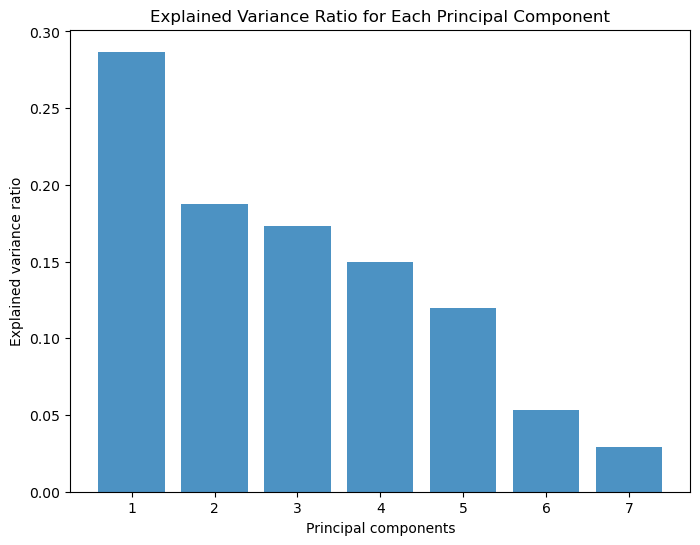

In [23]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio for each PC
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

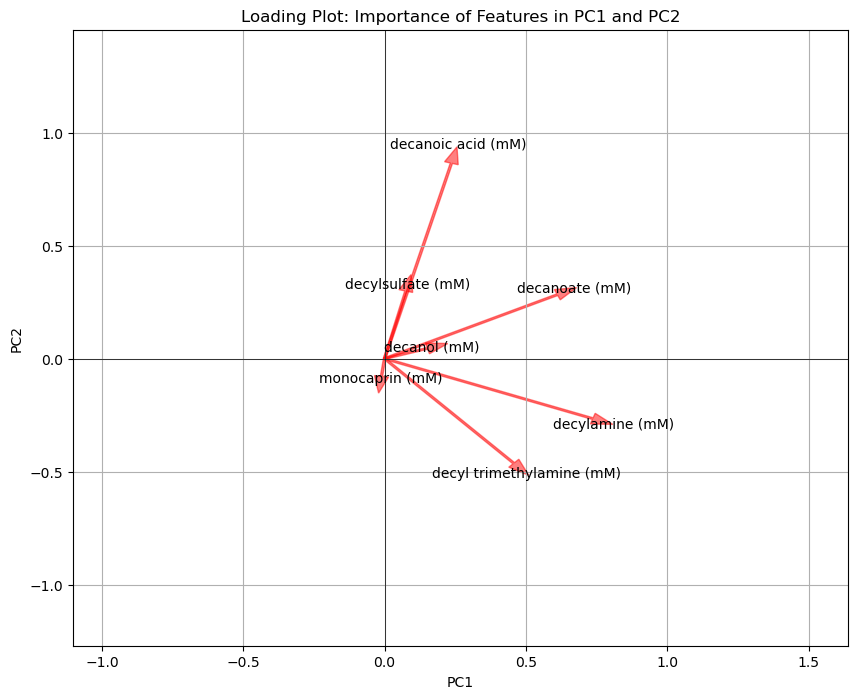

In [24]:
# Get the loadings for the first two PCs
loadings = pca.components_[:2, :]

# Feature names
feature_names = ['decanoic acid (mM)', 'decanoate (mM)',
                 'decylamine (mM)', 'decyl trimethylamine (mM)',
                 'decylsulfate (mM)', 'decanol (mM)',
                 'monocaprin (mM)']

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=feature_names)

# Plot loadings with arrows
plt.figure(figsize=(10, 8))
plt.title('Loading Plot: Importance of Features in PC1 and PC2')

# Scale factor for the arrows to make them visually appealing
scale_factor = 1.1

for feature in loadings_df.index:
    plt.arrow(0, 0, loadings_df.loc[feature, 'PC1'] * scale_factor, loadings_df.loc[feature, 'PC2'] * scale_factor,
              color='r', alpha=0.5, width=0.008, head_width=0.05)
    plt.text(loadings_df.loc[feature, 'PC1'] * scale_factor * 1.1, loadings_df.loc[feature, 'PC2'] * scale_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Set x and y limits based on PC1 and PC2 range
pc1_min, pc1_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
pc2_min, pc2_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()
plt.xlim(pc1_min - 0.05, pc1_max + 0.05)
plt.ylim(pc2_min - 0.05, pc2_max + 0.05)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [25]:
df_sample = pd.read_csv('df_sample_20240528.csv')

In [26]:
df_sample

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
0,0.392724,0.369573,0.120460,0.424857,0.591900,0.035454,0.230358
1,0.459205,0.685944,0.568357,0.320293,0.406413,0.154128,0.659858
2,0.206015,0.406974,0.298714,0.410124,0.436346,0.460685,0.236489
3,0.635155,0.293994,0.557038,0.137760,0.655182,0.595814,0.398491
4,0.192494,0.260856,0.159327,0.507569,0.086778,0.266699,0.450299
...,...,...,...,...,...,...,...
9999995,0.498363,0.577140,0.605472,0.221862,0.160296,0.612715,0.429254
9999996,0.679523,0.145563,0.451870,0.588802,0.008938,0.196234,0.431717
9999997,0.685342,0.660538,0.151012,0.514961,0.317437,0.315391,0.187897
9999998,0.309813,0.625423,0.496721,0.346873,0.114644,0.278361,0.576904


In [27]:
batch_size = 100000  # Define a suitable batch size
num_batches = len(df_sample) // batch_size

pred_probs = []

start_time = time.time()

for i in range(num_batches + 1):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df_sample))
    
    if start_idx >= len(df_sample):
        break
    
    batch = df_sample.values[start_idx:end_idx]
    pred_probs_batch = model.predict_proba(batch)
    pred_probs.extend(pred_probs_batch)

# Convert the list of probabilities back to a numpy array if needed
pred_probs = np.array(pred_probs)

end_time = time.time()

running_time = end_time - start_time
print("Running time:", running_time, "seconds")

Running time: 51.60577201843262 seconds


In [29]:
# Check the features difference between AL3 AL5 and AL4

In [33]:
df_input_update_ori = df_input_update.copy()
df_input_update_ori.iloc[:,0:7] = df_input_update_ori.iloc[:,0:7].applymap(lambda x: np.expm1(x))
df_input_update_ori 

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/1676378797.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input_update_ori.iloc[:,0:7] = df_input_update_ori.iloc[:,0:7].applymap(lambda x: np.expm1(x))


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.850,1.600,2.425,3.725,4.350,0.5550,0.785,1
1,3.425,0.905,0.192,1.875,2.375,0.2310,0.113,1
2,2.200,1.025,2.650,4.975,4.250,0.1725,0.225,1
3,3.625,4.975,0.465,0.074,3.375,0.8025,0.120,1
4,2.225,3.225,4.350,1.425,1.750,1.1175,0.350,1
...,...,...,...,...,...,...,...,...
283,1.150,0.735,1.200,0.265,1.850,0.7050,0.100,1
284,1.950,0.895,0.860,1.475,0.470,0.2775,0.099,1
285,0.006,1.375,0.600,0.960,1.700,0.2805,0.038,1
286,0.720,1.650,0.760,0.535,1.400,0.2325,0.280,1


In [60]:
df1 = df_input_update_ori.iloc[48*3: 48*3+48]
df2 = df_input_update_ori.iloc[48*4: 48*4+48]
df3 = df_input_update_ori.iloc[48*5: 48*5+48]

In [37]:
df1

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
144,0.980,0.370,0.141,0.840,2.400,0.3900,0.062,1
145,1.925,1.225,1.300,0.775,1.400,0.6375,0.051,1
146,2.400,0.146,0.083,0.740,1.325,0.1650,0.490,1
147,1.525,0.960,1.100,0.645,1.250,0.2130,0.460,1
148,1.750,1.650,0.014,0.395,2.250,0.5475,0.032,1
149,1.450,2.375,0.188,1.475,0.895,0.5100,0.265,1
150,2.200,1.025,0.020,0.475,1.675,0.0840,0.142,0
151,1.975,0.945,1.625,0.139,2.000,0.3675,0.065,1
152,1.975,0.575,0.465,0.430,1.700,0.5925,0.450,1
153,2.475,2.200,0.605,0.640,0.750,0.0675,0.350,1


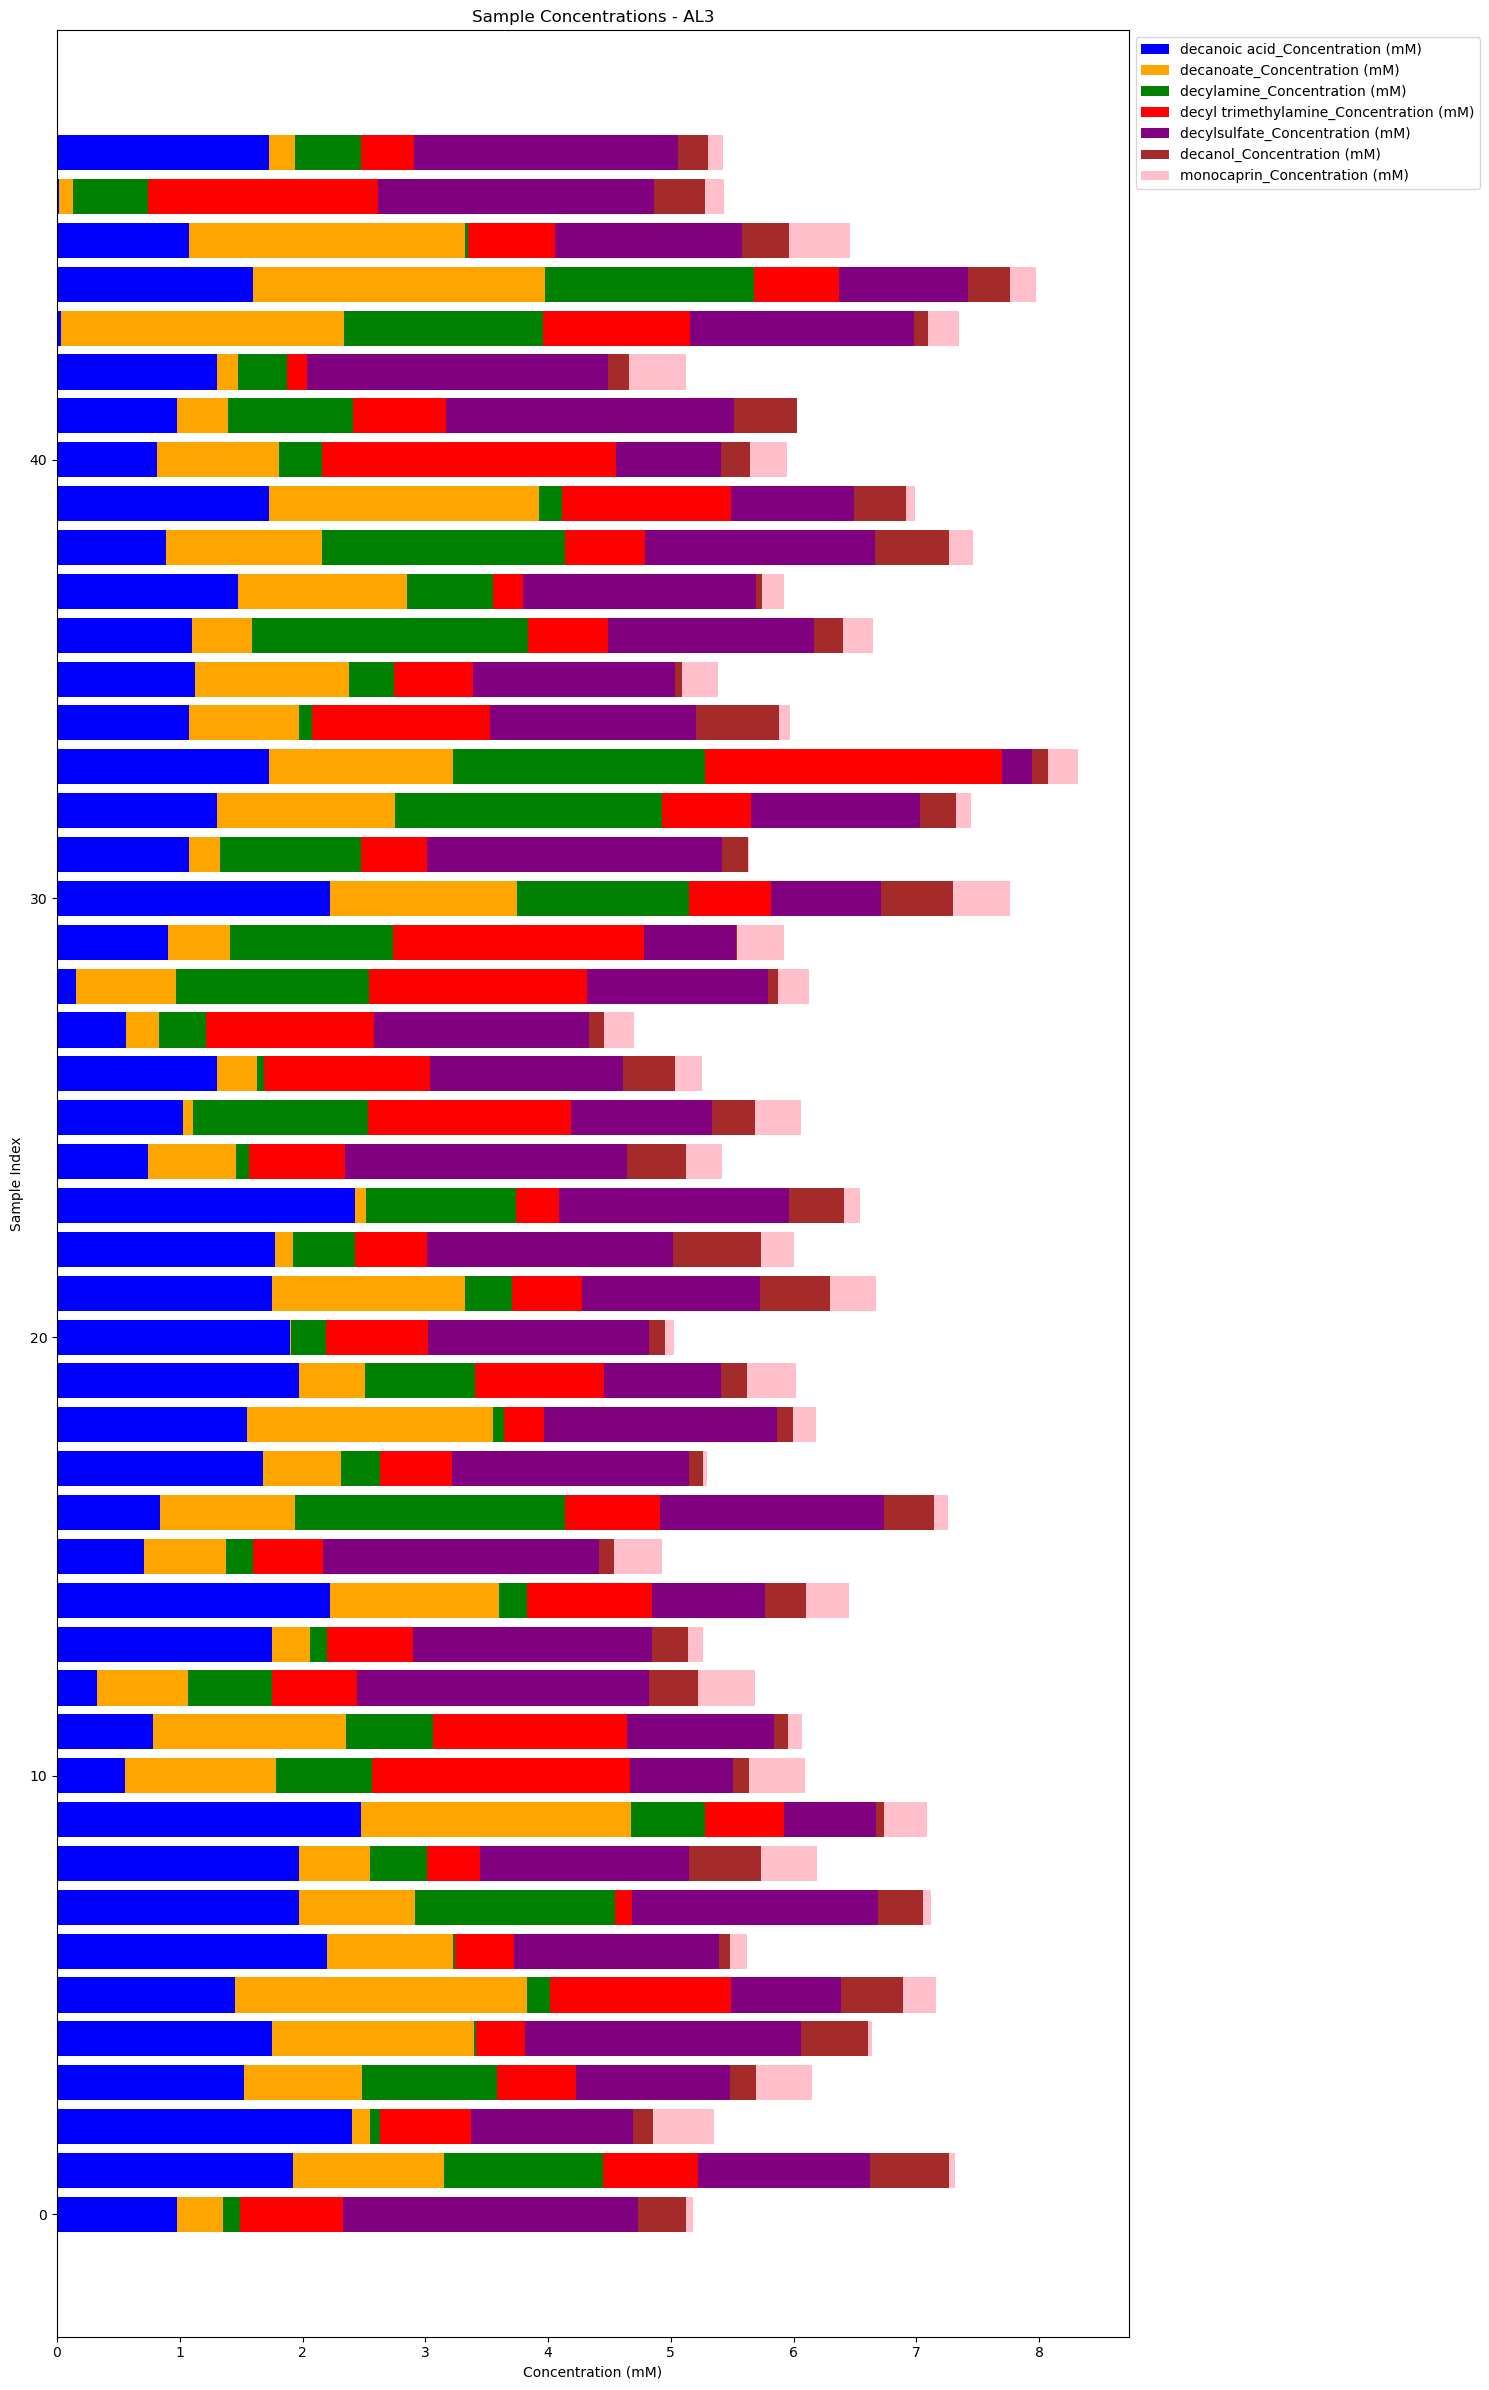

In [57]:
# Define a fixed color map for the features
color_map = {
    'decanoic acid_Concentration (mM)': 'blue',
    'decanoate_Concentration (mM)': 'orange',
    'decylamine_Concentration (mM)': 'green',
    'decyl trimethylamine_Concentration (mM)': 'red',
    'decylsulfate_Concentration (mM)': 'purple',
    'decanol_Concentration (mM)': 'brown',
    'monocaprin_Concentration (mM)': 'pink'
}

# Function to plot horizontal bars for each sample
def plot_samples(df, title, color_map):
    num_samples = df.shape[0]
    features = df.columns

    plt.figure(figsize=(15, num_samples * 0.5))

    for i in range(num_samples):
        sample = df.iloc[i, :]
        left = 0
        for feature in features:
            plt.barh(i, sample[feature], left=left, color=color_map[feature], label=feature if i == 0 else "")
            left += sample[feature]

    plt.xlabel('Concentration (mM)')
    plt.ylabel('Sample Index')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


# Plot df1
plot_samples(df1.drop('num_vesicles', axis=1), 'Sample Concentrations - AL3', color_map)

# Plot df2
# plot_samples(df2.drop('num_vesicles', axis=1), 'Sample Concentrations - df2')

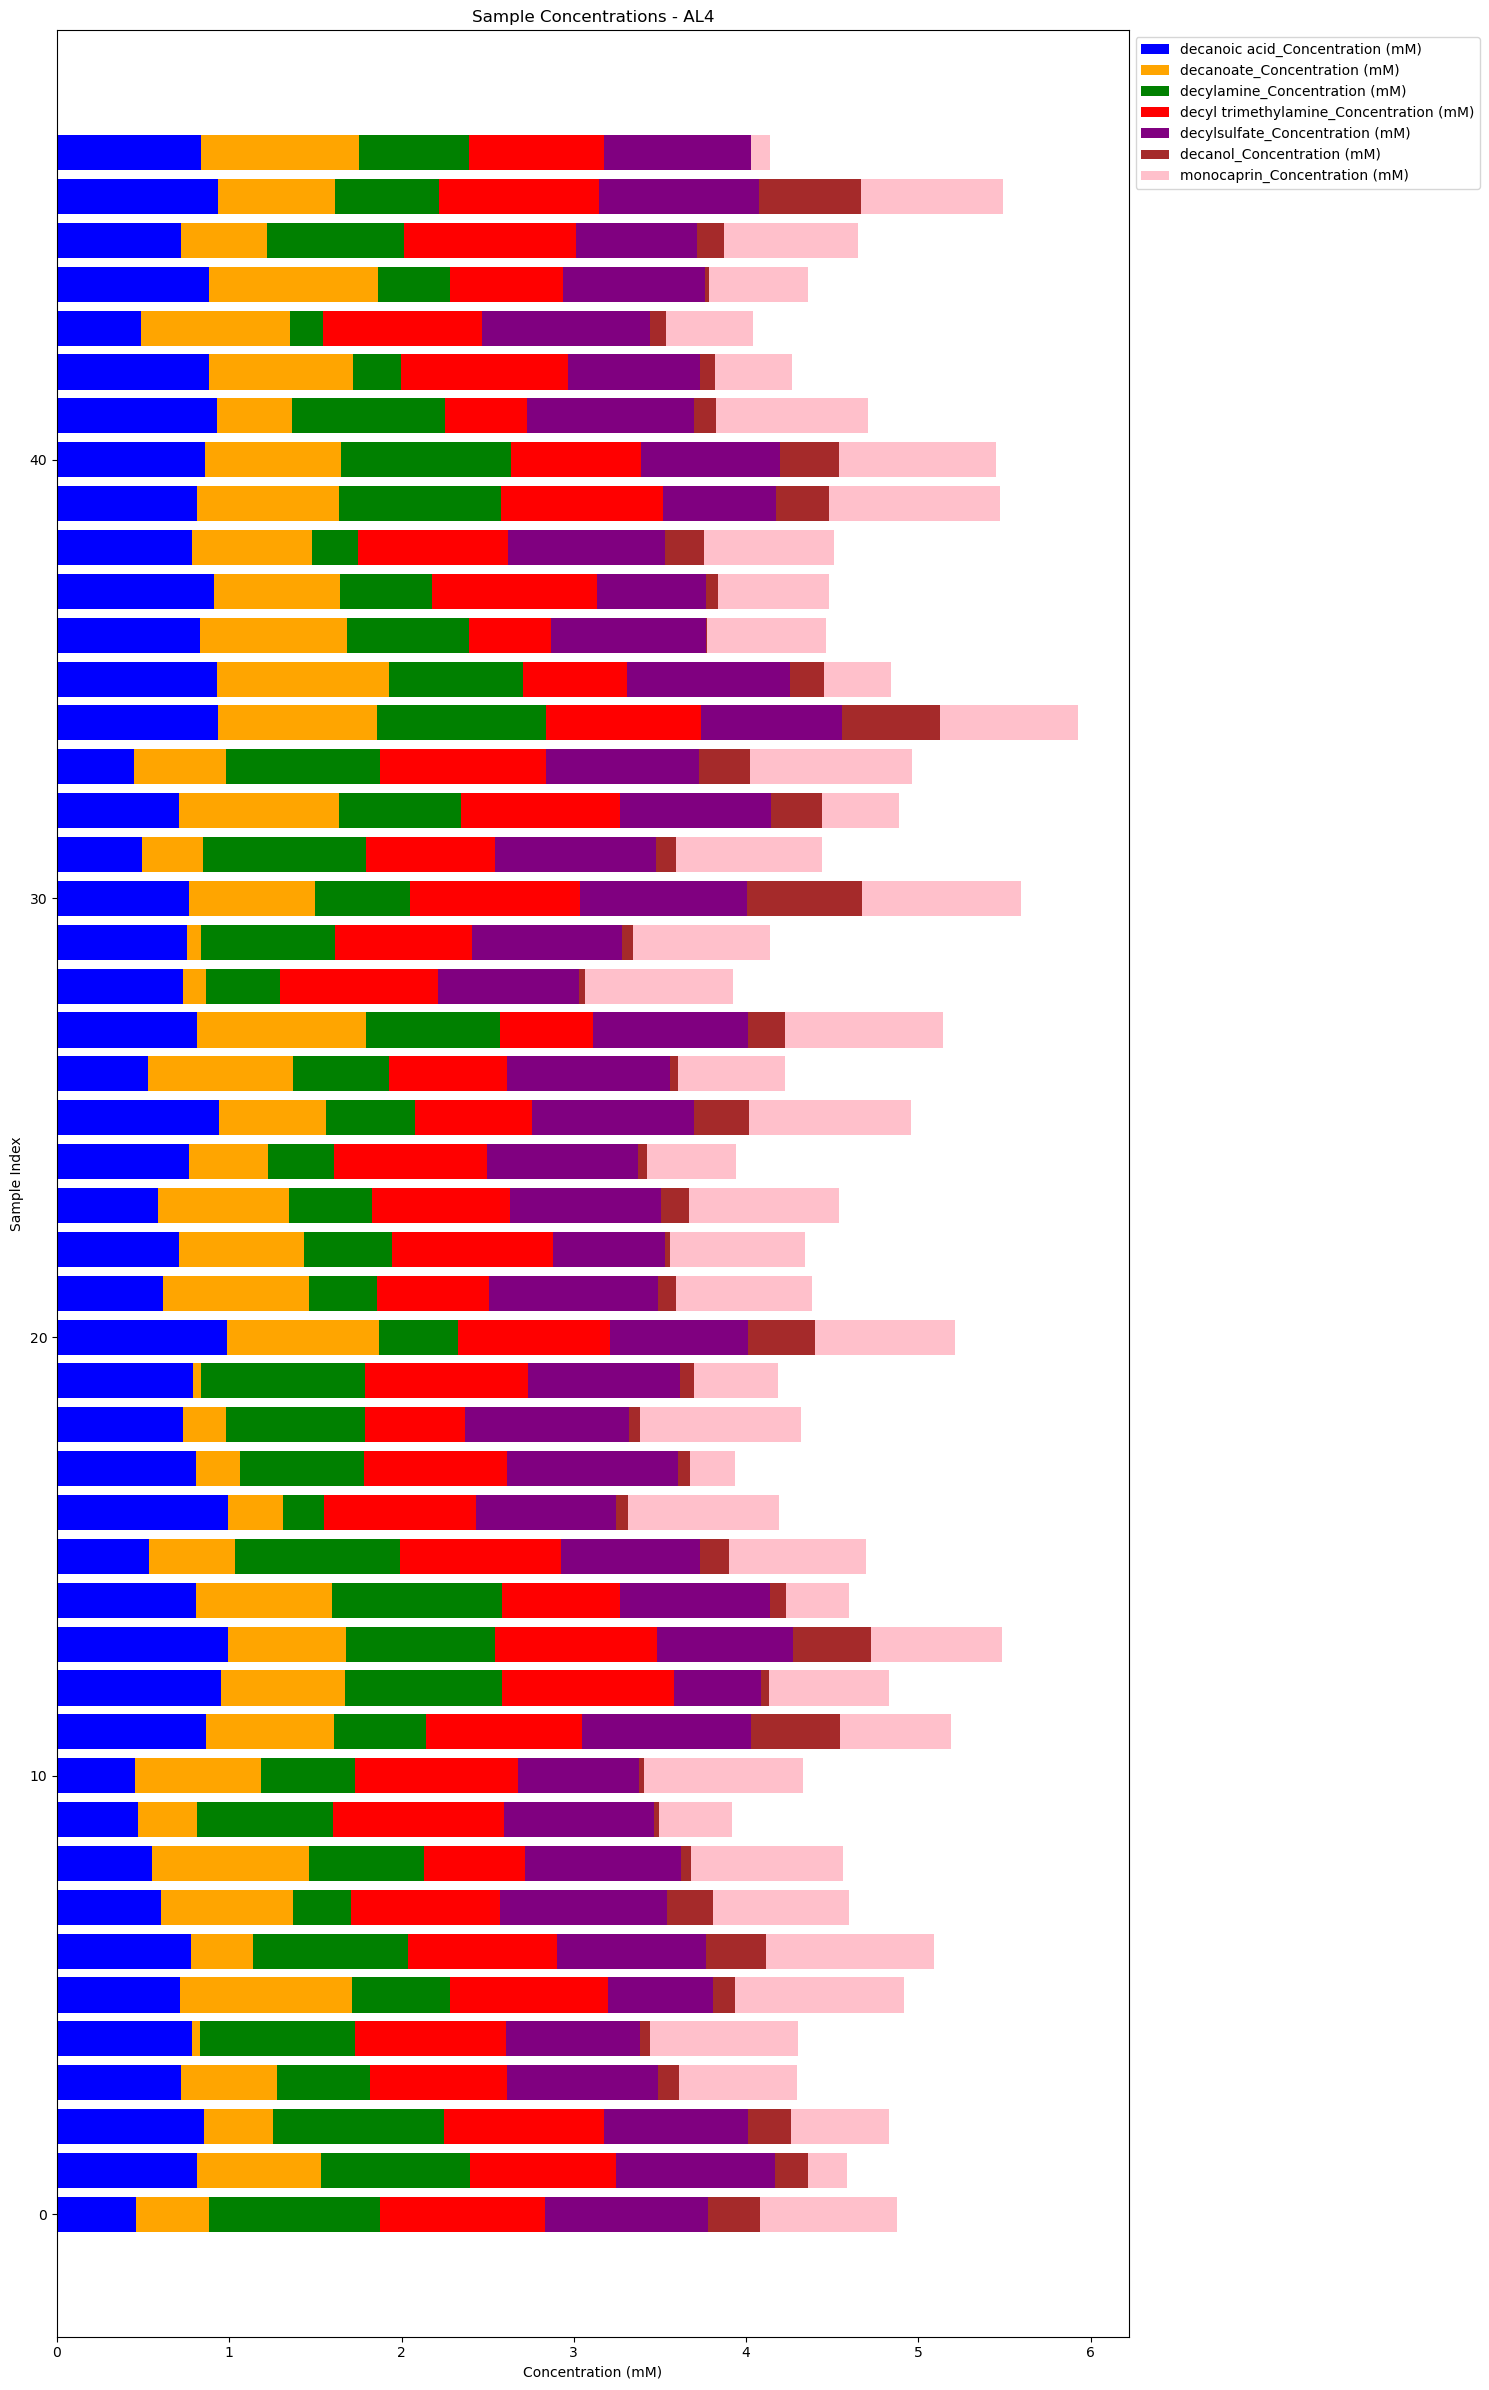

In [59]:
plot_samples(df2.drop('num_vesicles', axis=1), 'Sample Concentrations - AL4', color_map)

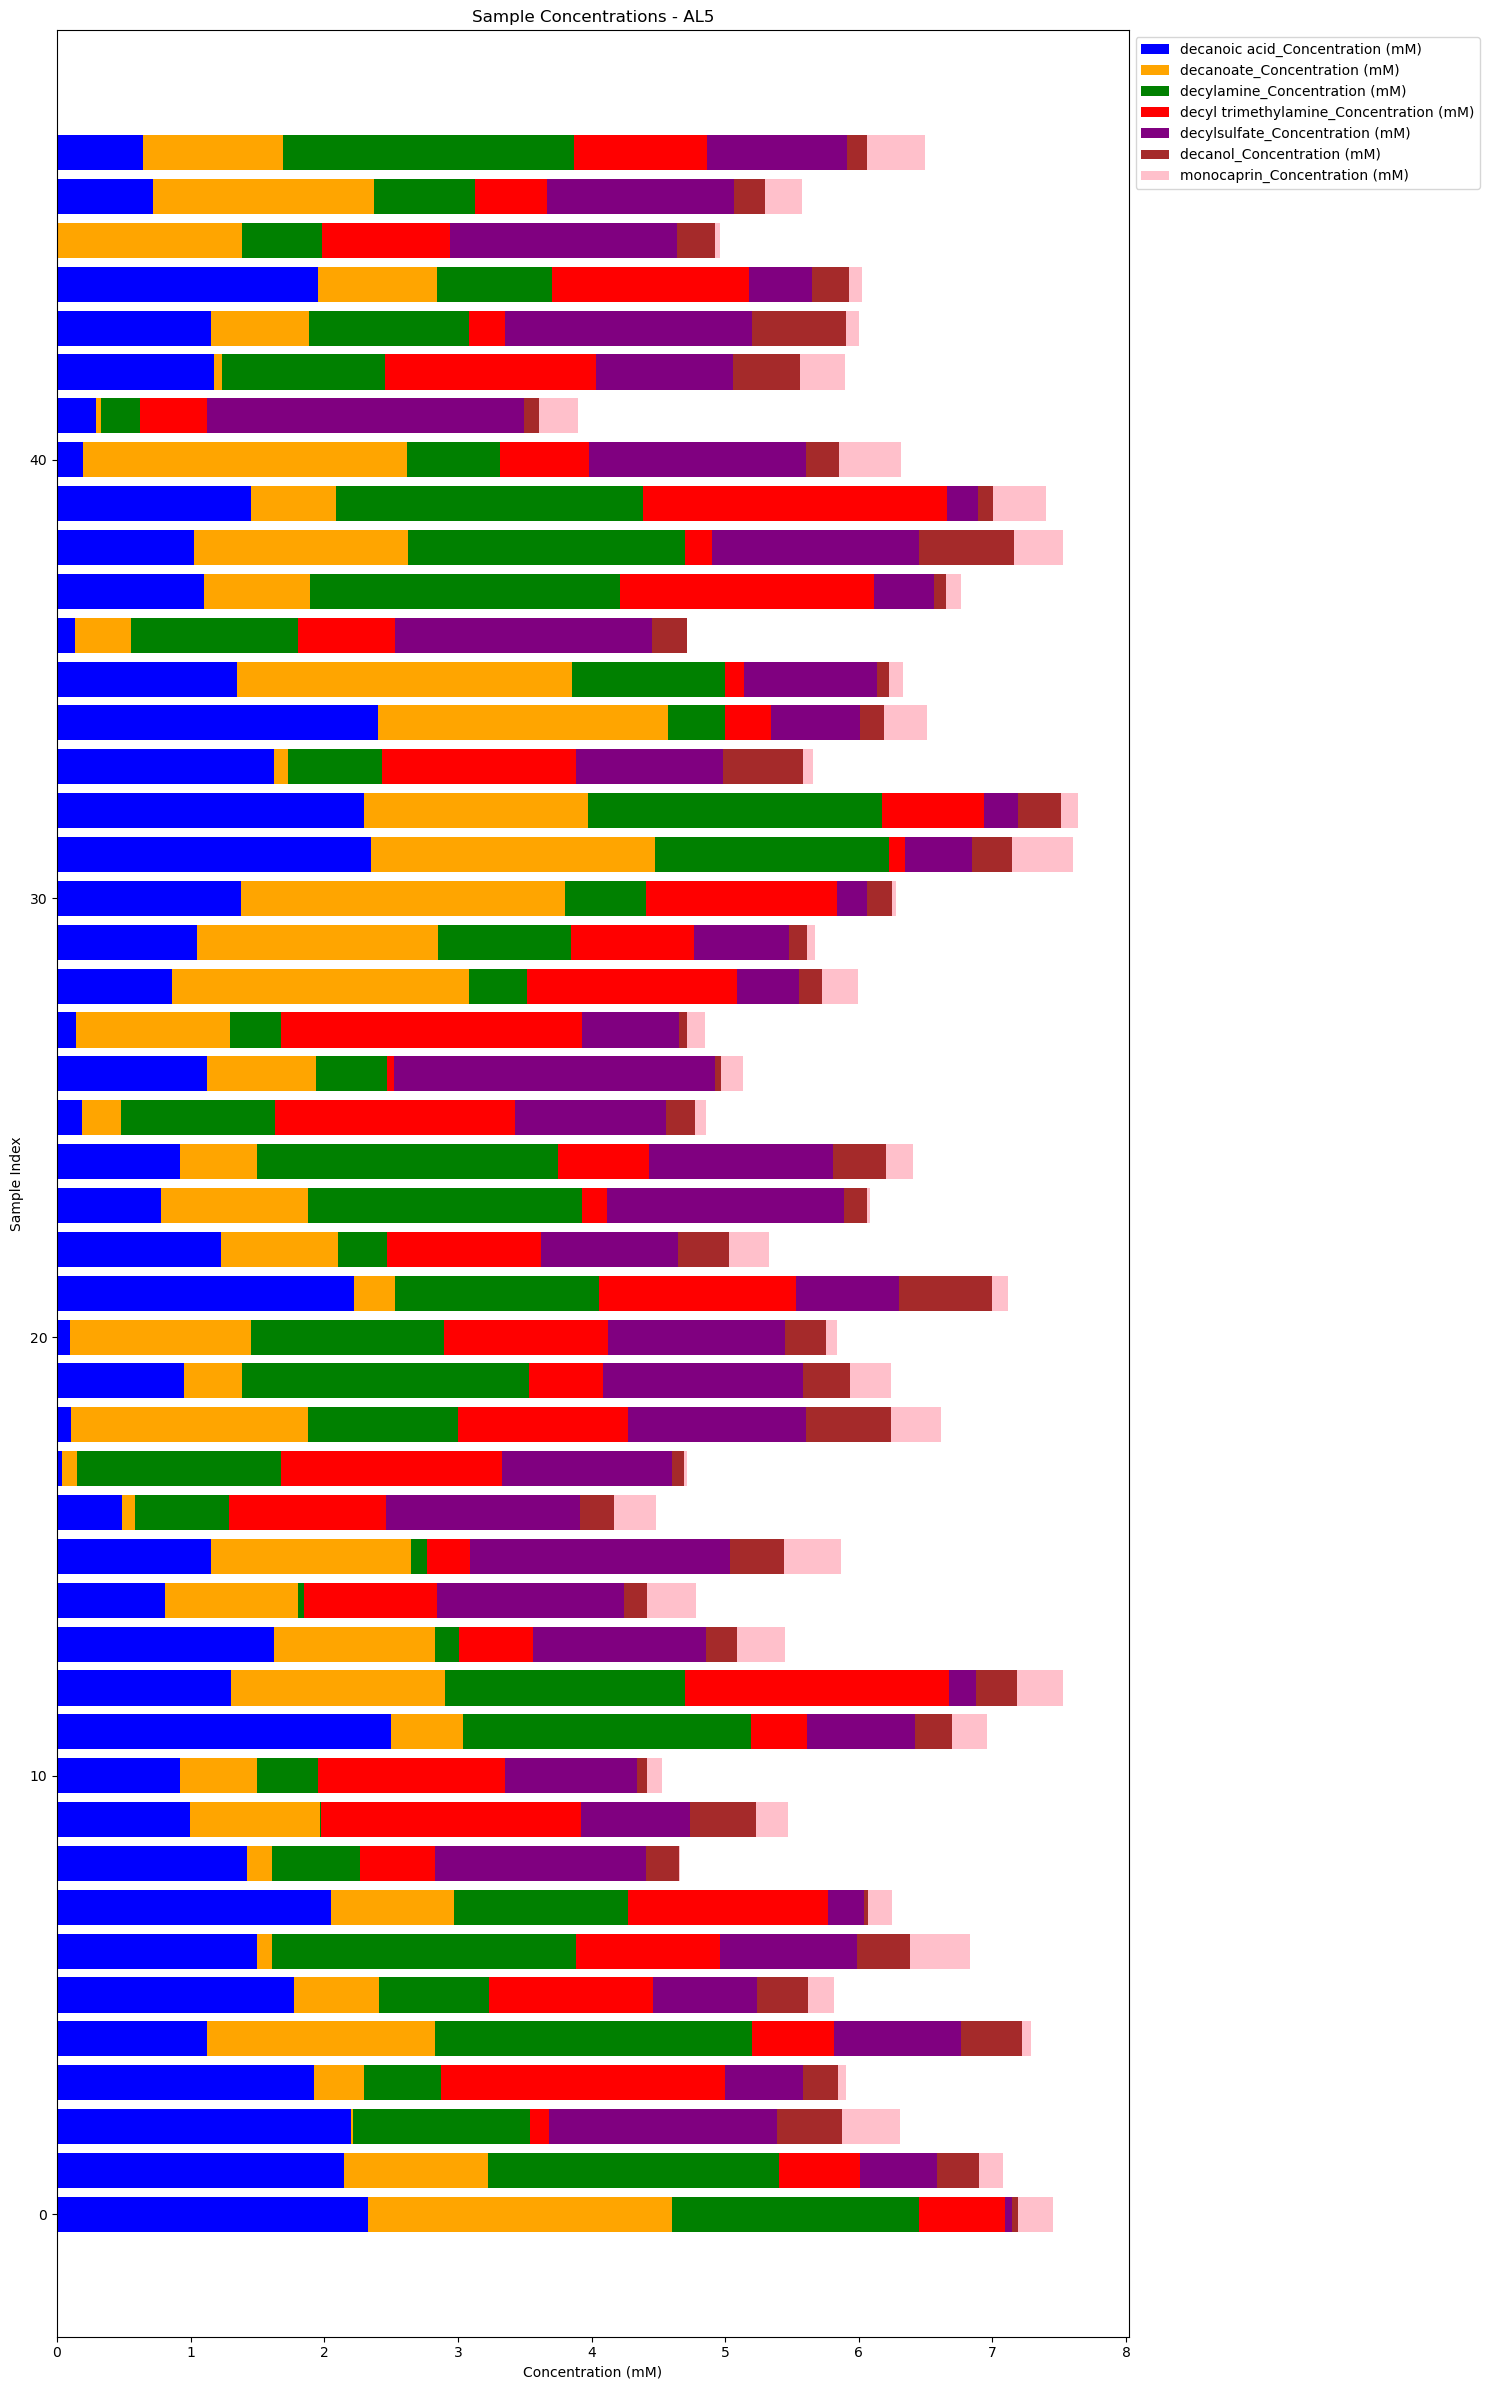

In [61]:
plot_samples(df3.drop('num_vesicles', axis=1), 'Sample Concentrations - AL5', color_map)

In [49]:
df3.columns

Index(['decanoic acid_Concentration (mM)', 'decanoate_Concentration (mM)',
       'decylamine_Concentration (mM)',
       'decyl trimethylamine_Concentration (mM)',
       'decylsulfate_Concentration (mM)', 'decanol_Concentration (mM)',
       'monocaprin_Concentration (mM)', 'num_vesicles'],
      dtype='object')

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/2785844761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['total_concentration'] = df1.drop('num_vesicles', axis=1).sum(axis=1)
/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/2785844761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['monocaprin_percentage'] = (df1['monocaprin_Concentration (mM)'] / df1['total_concentration']) * 100
/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/2785844761.p

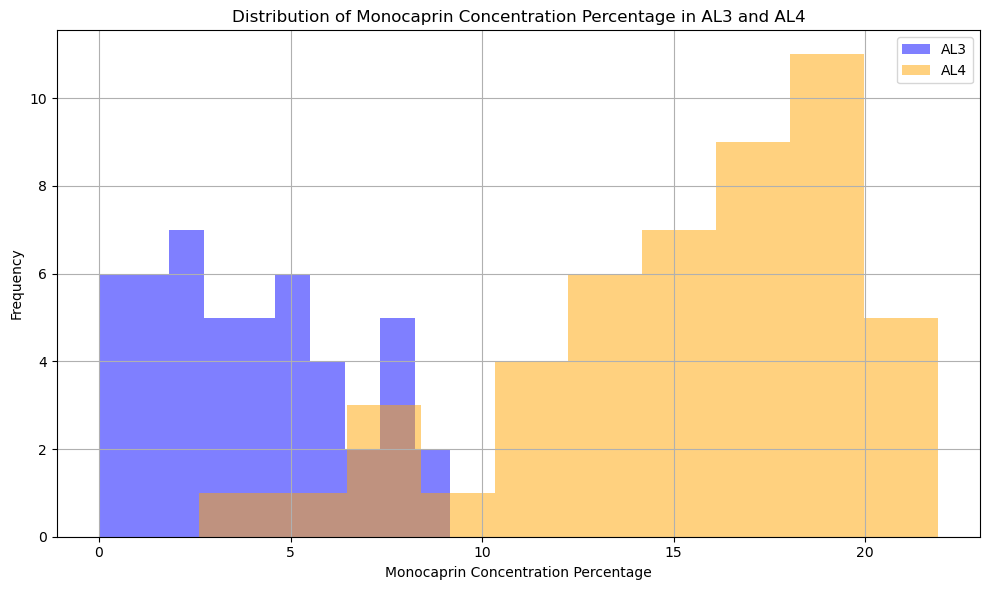

In [53]:
# Calculate the percentage of monocaprin_Concentration (mM) for each sample in df1
df1['total_concentration'] = df1.drop('num_vesicles', axis=1).sum(axis=1)
df1['monocaprin_percentage'] = (df1['monocaprin_Concentration (mM)'] / df1['total_concentration']) * 100

# Calculate the percentage of monocaprin_Concentration (mM) for each sample in df2
df2['total_concentration'] = df2.drop('num_vesicles', axis=1).sum(axis=1)
df2['monocaprin_percentage'] = (df2['monocaprin_Concentration (mM)'] / df2['total_concentration']) * 100

# Plot the distributions of the percentages
plt.figure(figsize=(10, 6))

plt.hist(df1['monocaprin_percentage'], bins=10, alpha=0.5, label='AL3', color='blue')
plt.hist(df2['monocaprin_percentage'], bins=10, alpha=0.5, label='AL4', color='orange')

plt.xlabel('Monocaprin Concentration Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Monocaprin Concentration Percentage in AL3 and AL4')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/2260841933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['total_concentration'] = df3.drop('num_vesicles', axis=1).sum(axis=1)
/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/2260841933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['monocaprin_percentage'] = (df3['monocaprin_Concentration (mM)'] / df3['total_concentration']) * 100
/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/2260841933.p

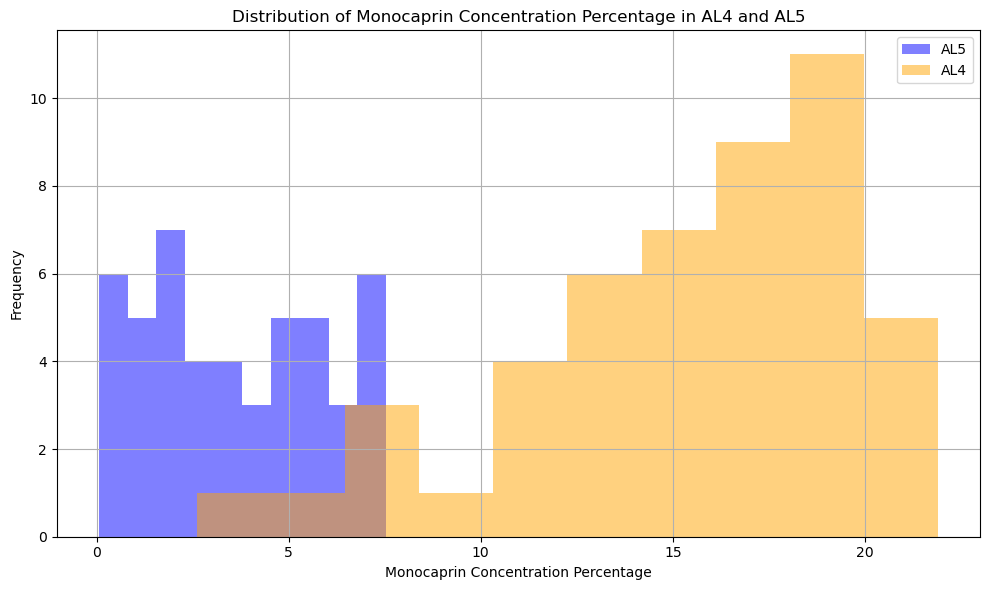

In [55]:
# Calculate the percentage of monocaprin_Concentration (mM) for each sample in df1
df3['total_concentration'] = df3.drop('num_vesicles', axis=1).sum(axis=1)
df3['monocaprin_percentage'] = (df3['monocaprin_Concentration (mM)'] / df3['total_concentration']) * 100

# Calculate the percentage of monocaprin_Concentration (mM) for each sample in df2
df2['total_concentration'] = df2.drop('num_vesicles', axis=1).sum(axis=1)
df2['monocaprin_percentage'] = (df2['monocaprin_Concentration (mM)'] / df2['total_concentration']) * 100

# Plot the distributions of the percentages
plt.figure(figsize=(10, 6))

plt.hist(df3['monocaprin_percentage'], bins=10, alpha=0.5, label='AL5', color='blue')
plt.hist(df2['monocaprin_percentage'], bins=10, alpha=0.5, label='AL4', color='orange')

plt.xlabel('Monocaprin Concentration Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Monocaprin Concentration Percentage in AL4 and AL5')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

In [63]:
# randomly sample the smaller space (with or without the restrictions on monocaprin)

In [65]:
median_value=6.0680000000000005

In [66]:
import torch

original_bounds = torch.tensor([[0., 0., 0., 0., 0., 0., 0.],
                                [1., 1., 1., 1., 1., 1., 1.]])

# Sample points in the 7-dimensional space until we get the required number of valid samples
num_required_samples = 10000000
num_dimensions = original_bounds.shape[1]
valid_samples = torch.empty((0, num_dimensions))

while len(valid_samples) < num_required_samples:
    # Generate random samples in the original space
    samples = torch.rand(num_required_samples, num_dimensions)  # Generate random samples in [0, 1)

    # Scale the samples to the specified original bounds
    scaled_samples = samples * (original_bounds[1] - original_bounds[0]) + original_bounds[0]

    # Calculate the sum of the features
    total_concentration = scaled_samples.sum(dim=1)

    # Apply the constraints
    valid_samples_batch = scaled_samples[
        (total_concentration < median_value) & (scaled_samples[:, -1] < 0.1 * total_concentration)
    ]

    # Append valid samples to the tensor
    valid_samples = torch.cat((valid_samples, valid_samples_batch), dim=0)

    # Truncate the tensor to the required number of samples if it exceeds
    if len(valid_samples) > num_required_samples:
        valid_samples = valid_samples[:num_required_samples]

# Ensure we have exactly the required number of samples
valid_samples = valid_samples[:num_required_samples]

# Apply log1p transform to the valid samples
valid_samples1 = torch.log1p(valid_samples)

print(valid_samples1.shape) 

torch.Size([10000000, 7])


In [67]:
import torch

original_bounds = torch.tensor([[0., 0., 0., 0., 0., 0., 0.],
                                [1., 1., 1., 1., 1., 1., 1.]])

# Sample points in the 7-dimensional space until we get the required number of valid samples
num_required_samples = 10000000
num_dimensions = original_bounds.shape[1]
valid_samples = torch.empty((0, num_dimensions))

while len(valid_samples) < num_required_samples:
    # Generate random samples in the original space
    samples = torch.rand(num_required_samples, num_dimensions)  # Generate random samples in [0, 1)

    # Scale the samples to the specified original bounds
    scaled_samples = samples * (original_bounds[1] - original_bounds[0]) + original_bounds[0]

    # Calculate the sum of the features
    total_concentration = scaled_samples.sum(dim=1)

    # Apply the constraints
    valid_samples_batch = scaled_samples[
        (total_concentration < median_value) &
        (scaled_samples[:, -1] >= 0.1 * total_concentration) &
        (scaled_samples[:, -1] <= 0.2 * total_concentration)
    ]

    # Append valid samples to the tensor
    valid_samples = torch.cat((valid_samples, valid_samples_batch), dim=0)

    # Truncate the tensor to the required number of samples if it exceeds
    if len(valid_samples) > num_required_samples:
        valid_samples = valid_samples[:num_required_samples]

# Ensure we have exactly the required number of samples
valid_samples = valid_samples[:num_required_samples]

# Apply log1p transform to the valid samples
valid_samples2 = torch.log1p(valid_samples)

print(valid_samples2.shape) 

torch.Size([10000000, 7])


In [68]:
import torch

original_bounds = torch.tensor([[0., 0., 0., 0., 0., 0., 0.],
                                [1., 1., 1., 1., 1., 1., 1.]])

# Sample points in the 7-dimensional space until we get the required number of valid samples
num_required_samples = 10000000
num_dimensions = original_bounds.shape[1]
valid_samples = torch.empty((0, num_dimensions))

while len(valid_samples) < num_required_samples:
    # Generate random samples in the original space
    samples = torch.rand(num_required_samples, num_dimensions)  # Generate random samples in [0, 1)

    # Scale the samples to the specified original bounds
    scaled_samples = samples * (original_bounds[1] - original_bounds[0]) + original_bounds[0]

    # Calculate the sum of the features
    total_concentration = scaled_samples.sum(dim=1)

    # Apply the constraints
    valid_samples_batch = scaled_samples[
        (total_concentration < median_value) &
        (scaled_samples[:, -1] >= 0.2 * total_concentration) &
        (scaled_samples[:, -1] <= 0.3 * total_concentration)
    ]

    # Append valid samples to the tensor
    valid_samples = torch.cat((valid_samples, valid_samples_batch), dim=0)

    # Truncate the tensor to the required number of samples if it exceeds
    if len(valid_samples) > num_required_samples:
        valid_samples = valid_samples[:num_required_samples]

# Ensure we have exactly the required number of samples
valid_samples = valid_samples[:num_required_samples]

# Apply log1p transform to the valid samples
valid_samples3 = torch.log1p(valid_samples)

print(valid_samples3.shape) 

torch.Size([10000000, 7])


In [72]:
df_sample1 = pd.DataFrame(valid_samples1, columns=[df_input_update.iloc[:,0:7].columns])
df_sample2 = pd.DataFrame(valid_samples2, columns=[df_input_update.iloc[:,0:7].columns])
df_sample3 = pd.DataFrame(valid_samples3, columns=[df_input_update.iloc[:,0:7].columns])

In [74]:
pred_probs1 = cal_prob(df_sample1, model, batch_size=100000)
pred_probs2 = cal_prob(df_sample2, model, batch_size=100000)
pred_probs3 = cal_prob(df_sample3, model, batch_size=100000)

Running time: 50.54302477836609 seconds
Running time: 50.76742696762085 seconds
Running time: 51.24001598358154 seconds


In [78]:
def cal_vesicles_per(pred_probs):
    # Extract the second column
    second_column = pred_probs[:, 1]
    plt.hist(second_column)
    
    # Transform values: >0.5 to 1, else 0
    transformed = np.where(second_column >= 0.5, 1, 0)
    
    # Calculate the percentage of 1s
    percentage_of_ones = np.mean(transformed) * 100
    
    print(f"Percentage of 1s: {percentage_of_ones:.4f}%")
    return percentage_of_ones

Percentage of 1s: 0.0784%
Percentage of 1s: 0.0012%
Percentage of 1s: 0.0000%


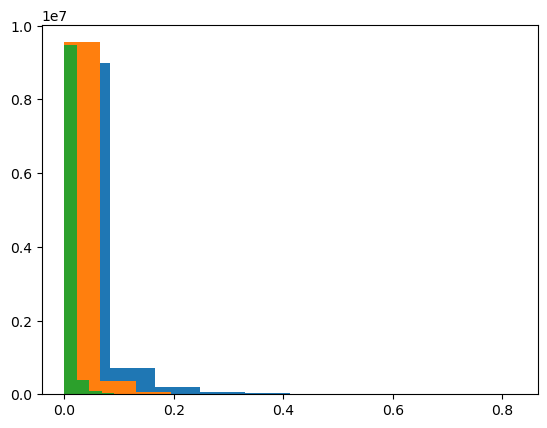

In [79]:
# Calculatign percent of samples of forming vesicles
p1 = cal_vesicles_per(pred_probs1)
p2 = cal_vesicles_per(pred_probs2)
p3 = cal_vesicles_per(pred_probs3)

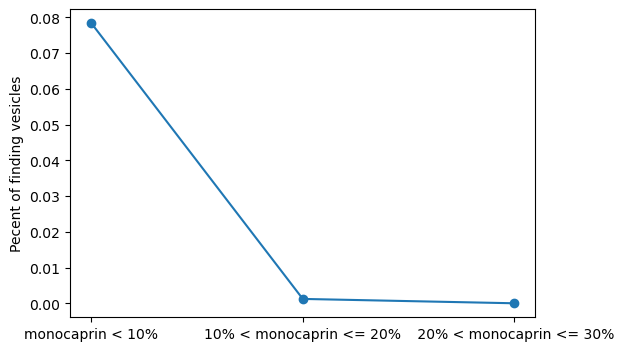

In [80]:
p = [ p1, p2, p3]

# Plot the trend
plt.figure(figsize=(6, 4))
plt.plot(p, marker='o')

# Add labels and title
# plt.xlabel('AL round')
plt.ylabel('Pecent of finding vesicles')
plt.xticks([0, 1, 2], ['monocaprin < 10%', '10% < monocaprin <= 20%', ' 20% < monocaprin <= 30%'])  # Label the x-axis ticks
plt.show()

In [81]:
# Exploitation
# randomly sample the smaller total concentration space (with higer probability of finding vesicles)

In [127]:
import numpy as np
import time

original_bounds = np.array([[0., 0., 0., 0., 0., 0., 0.],[5., 5., 5., 5., 5., 1.5, 1.0]])
num_required_samples = 10000000
num_dimensions = original_bounds.shape[1]

# Define a simpler distribution (e.g., uniform) covering the original bounds
low = original_bounds[0]
high = original_bounds[1]

start_time = time.time()  # Record start time

valid_samples = []
while len(valid_samples) < num_required_samples:
  # Generate samples
  samples = np.random.uniform(low=low, high=high, size=(num_generate_samples, num_dimensions))

  # Calculate the sum of the features
  total_concentration = samples.sum(axis=1)

  # Reject samples violating the constraint (total_concentration < 3)
  valid_samples_batch = samples[total_concentration < 3]

  # Append valid samples and truncate if needed
  valid_samples.extend(valid_samples_batch.tolist())
  if len(valid_samples) > num_required_samples:
    valid_samples = valid_samples[:num_required_samples]

# Ensure we have exactly the required number of samples
valid_samples = np.array(valid_samples[:num_required_samples])

# Apply log1p transform
valid_samples3 = np.log1p(valid_samples)
print(valid_samples3.shape)

end_time = time.time()  # Record end time

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


(10000000, 7)
Execution time: 6561.55 seconds


In [128]:
6561/30

218.7

In [126]:
valid_samples3

tensor([[0.2419, 0.5732, 0.0043,  ..., 0.7241, 0.0368, 0.1021],
        [0.1121, 0.0749, 0.4291,  ..., 0.5360, 0.3974, 0.5515],
        [0.0910, 0.5638, 0.0851,  ..., 0.2648, 0.1144, 0.2131],
        ...,
        [0.0434, 0.2373, 0.3157,  ..., 0.2274, 0.3140, 0.4065],
        [0.6336, 0.4458, 0.1328,  ..., 0.0590, 0.1073, 0.1105],
        [0.5251, 0.2420, 0.6919,  ..., 0.3157, 0.0480, 0.0309]])

In [129]:
np.save('valid_samples3.npy', valid_samples3)

In [130]:
# df_sample1 = pd.DataFrame(valid_samples1, columns=[df_input_update.iloc[:,0:7].columns])
# df_sample2 = pd.DataFrame(valid_samples2, columns=[df_input_update.iloc[:,0:7].columns])
df_sample3 = pd.DataFrame(valid_samples3, columns=[df_input_update.iloc[:,0:7].columns])

# pred_probs1 = cal_prob(df_sample1, model, batch_size=100000)
# pred_probs2 = cal_prob(df_sample2, model, batch_size=100000)
pred_probs3 = cal_prob(df_sample3, model, batch_size=100000)

Running time: 49.04361319541931 seconds


(array([9.533312e+06, 3.136140e+05, 9.152300e+04, 3.545700e+04,
        1.535300e+04, 6.656000e+03, 2.814000e+03, 9.930000e+02,
        2.580000e+02, 2.000000e+01]),
 array([4.79501051e-04, 6.71999475e-02, 1.33920394e-01, 2.00640840e-01,
        2.67361287e-01, 3.34081733e-01, 4.00802180e-01, 4.67522626e-01,
        5.34243073e-01, 6.00963519e-01, 6.67683966e-01]),
 <BarContainer object of 10 artists>)

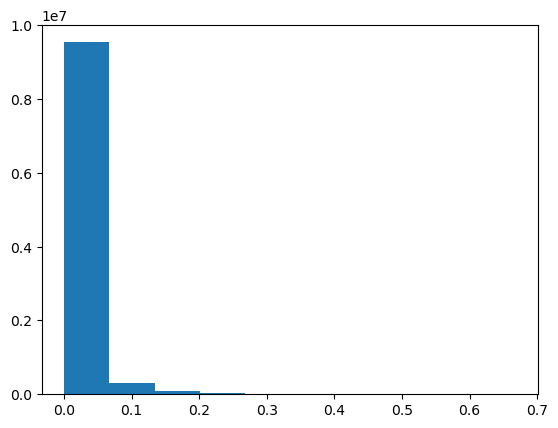

In [131]:
second_column = pred_probs3[:, 1]
plt.hist(second_column)

In [132]:
second_column.max()

0.6676839657068854

In [133]:
second_column[second_column>=0.5].shape

(625,)

In [138]:
test = second_column[second_column>=0.5]

In [139]:
sorted(test)

[0.5000262502853242,
 0.5000763685217108,
 0.5000938585381621,
 0.5001410546939166,
 0.5002073860409488,
 0.5002925580947463,
 0.5003238997577567,
 0.5003318713682855,
 0.5004610004780641,
 0.5005118332965457,
 0.5006098767349401,
 0.5006168055813764,
 0.5007732365349615,
 0.5007928174561205,
 0.5008935012723059,
 0.5009827611933375,
 0.5010401213749316,
 0.5010511291633248,
 0.5010607676910954,
 0.5011872035126155,
 0.50121393752752,
 0.5012646066542712,
 0.5013014796901261,
 0.501650074731296,
 0.5018351146946296,
 0.5018677816789103,
 0.5019149489804327,
 0.5019617218067003,
 0.5019627534647393,
 0.501979832076707,
 0.5020342910016811,
 0.5020719912881599,
 0.502126569758202,
 0.5021955230728619,
 0.502290359417632,
 0.5022975822004767,
 0.5023547219597431,
 0.5023928096693817,
 0.5024670973360763,
 0.5024948946312451,
 0.5025192359273252,
 0.502545297484402,
 0.5025634772018162,
 0.5027148744544334,
 0.5028860205890364,
 0.5031174768701216,
 0.5033864933354399,
 0.5034089964658381,

In [217]:
pred_probs3[:, 1]

array([0.03126102, 0.00459166, 0.00153831, ..., 0.00616971, 0.00539244,
       0.00406218])

In [221]:
top_indices3 = np.argsort(pred_probs3[:, 1])[::-1][:48]
candidates3 = df_sample3.iloc[top_indices3]
original_scale_df3 = np.expm1(candidates3)
candidates3

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
4346298,0.013771,0.007064,0.057760,0.852758,0.927423,0.014131,0.019747
6470933,0.002699,0.016251,0.038460,0.714906,1.014349,0.056752,0.025173
6333077,0.105799,0.008501,0.067231,0.723127,0.992929,0.011443,0.025963
5831635,0.024478,0.081388,0.013936,0.658386,1.049955,0.024315,0.047062
2717418,0.100527,0.050327,0.000671,0.720372,0.987713,0.079367,0.017083
6762071,0.046129,0.006837,0.059319,0.807353,0.924279,0.045438,0.052677
7352620,0.043124,0.017857,0.113787,0.581883,1.075481,0.021663,0.070545
1883740,0.018714,0.028180,0.067399,0.654433,1.036535,0.001065,0.095095
4339246,0.066318,0.012036,0.023560,0.827249,0.904927,0.098511,0.007791
2273461,0.115483,0.073397,0.098518,0.718909,0.956490,0.015691,0.002331


In [222]:
candidates3['total_concentration'] = candidates3.sum(axis=1)
candidates3

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_60244/487505452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates3['total_concentration'] = candidates3.sum(axis=1)


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),total_concentration
4346298,0.013771,0.007064,0.057760,0.852758,0.927423,0.014131,0.019747,1.892653
6470933,0.002699,0.016251,0.038460,0.714906,1.014349,0.056752,0.025173,1.868591
6333077,0.105799,0.008501,0.067231,0.723127,0.992929,0.011443,0.025963,1.934993
5831635,0.024478,0.081388,0.013936,0.658386,1.049955,0.024315,0.047062,1.899520
2717418,0.100527,0.050327,0.000671,0.720372,0.987713,0.079367,0.017083,1.956061
6762071,0.046129,0.006837,0.059319,0.807353,0.924279,0.045438,0.052677,1.942032
7352620,0.043124,0.017857,0.113787,0.581883,1.075481,0.021663,0.070545,1.924340
1883740,0.018714,0.028180,0.067399,0.654433,1.036535,0.001065,0.095095,1.901420
4339246,0.066318,0.012036,0.023560,0.827249,0.904927,0.098511,0.007791,1.940393
2273461,0.115483,0.073397,0.098518,0.718909,0.956490,0.015691,0.002331,1.980819


In [233]:
original_scale_df3['total_concentration'] = original_scale_df3.sum(axis=1)
original_scale_df3

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),total_concentration
4346298,0.013866,0.007089,0.059461,1.346107,1.527987,0.014231,0.019943,2.988684
6470933,0.002702,0.016384,0.039210,1.043995,1.757567,0.058393,0.025493,2.943744
6333077,0.111599,0.008537,0.069543,1.060868,1.699129,0.011508,0.026303,2.987486
5831635,0.024780,0.084792,0.014033,0.931672,1.857522,0.024613,0.048187,2.985599
2717418,0.105753,0.051615,0.000672,1.055197,1.685088,0.082601,0.017229,2.998156
6762071,0.047210,0.006860,0.061113,1.241965,1.520052,0.046487,0.054089,2.977775
7352620,0.044067,0.018018,0.120513,0.789405,1.931401,0.021899,0.073093,2.998397
1883740,0.018890,0.028581,0.069722,0.924051,1.819429,0.001065,0.099763,2.961502
4339246,0.068566,0.012108,0.023840,1.287019,1.471752,0.103527,0.007822,2.974635
2273461,0.122415,0.076158,0.103534,1.052194,1.602545,0.015815,0.002334,2.974995


(array([ 1.,  0.,  2.,  2.,  2.,  4.,  4.,  4., 11., 18.]),
 array([2.80967717, 2.82854913, 2.84742109, 2.86629304, 2.885165  ,
        2.90403696, 2.92290892, 2.94178088, 2.96065283, 2.97952479,
        2.99839675]),
 <BarContainer object of 10 artists>)

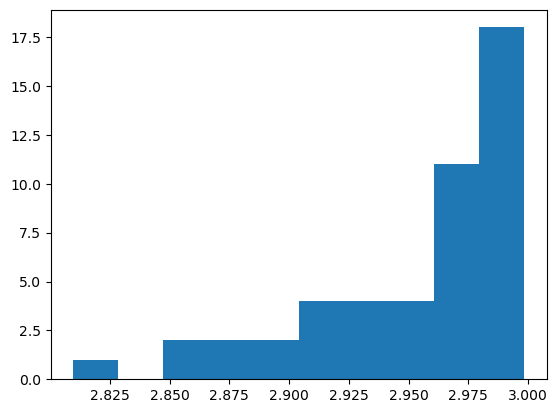

In [234]:
plt.hist(original_scale_df3['total_concentration'])

(array([ 3.,  1.,  2.,  0.,  3.,  7., 12.,  9.,  6.,  5.]),
 array([1.75828036, 1.78343219, 1.80858402, 1.83373586, 1.85888769,
        1.88403952, 1.90919135, 1.93434318, 1.95949501, 1.98464684,
        2.00979867]),
 <BarContainer object of 10 artists>)

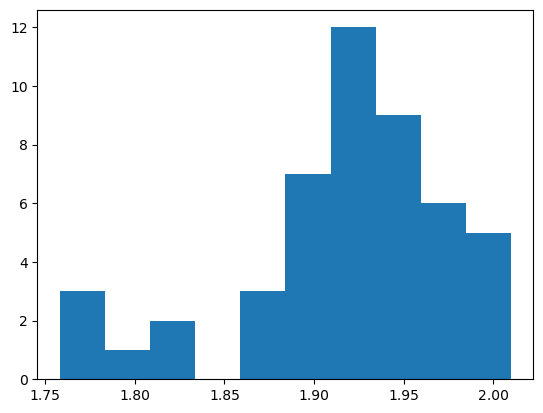

In [235]:
plt.hist(candidates3['total_concentration'])

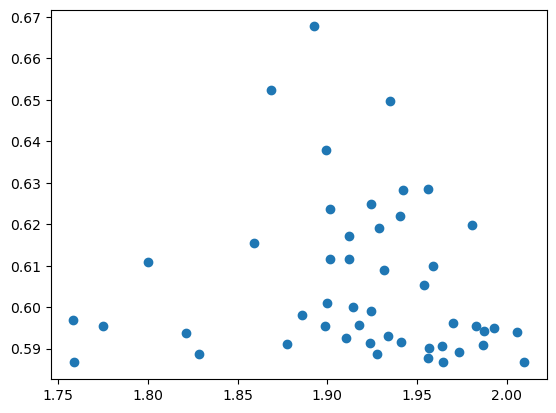

In [236]:
p = pred_probs3[:, 1][top_indices3]
t = candidates3['total_concentration']
plt.scatter(t, p)

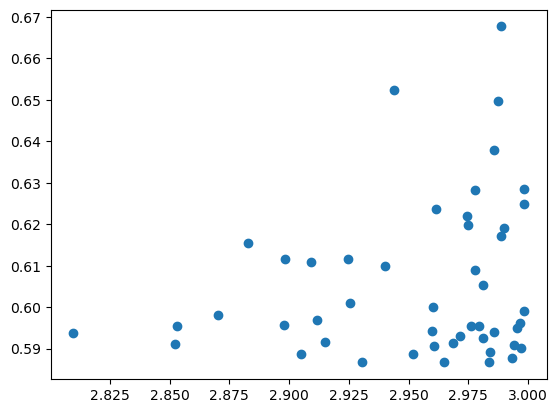

In [237]:
p = pred_probs3[:, 1][top_indices3]
t = original_scale_df3['total_concentration']
plt.scatter(t, p)

### Create dispense volume

In [239]:
df_final = original_scale_df3.iloc[:,0:-1]
df_final.to_csv('original_scale_df_GPC_20240623.csv', index=False)

In [242]:
solutes = ['decanoic acid', 'decanoate', 'decylamine', 'decyl trimethylamine', 'decylsulfate', 'decanol', 'monocaprin']
dispense_df = get_dispense_volume(df_final, solutes, allow_zero=True)
len(dispense_df)

48

In [249]:
# New column names
new_column_names = ['decanoic acid_Concentration  (50 mM)',
       'decanoic acid_Concentration  (10 mM)',
       'decanoic acid_Concentration  (2 mM)',
       'decanoate_Concentration  (50 mM)', 'decanoate_Concentration  (10 mM)',
       'decanoate_Concentration  (2 mM)', 'decylamine_Concentration  (50 mM)',
       'decylamine_Concentration  (10 mM)', 'decylamine_Concentration  (2 mM)',
       'decyl trimethylamine_Concentration  (50 mM)',
       'decyl trimethylamine_Concentration  (10 mM)',
       'decyl trimethylamine_Concentration  (2 mM)',
       'decylsulfate_Concentration  (50 mM)',
       'decylsulfate_Concentration  (10 mM)',
       'decylsulfate_Concentration  (2 mM)', 'decanol_Concentration  (15 mM)',
       'decanol_Concentration  (3 mM)', 'monocaprin_Concentration  (10 mM)',
       'monocaprin_Concentration  (2 mM)']

# Rename columns
dispense_df.columns = new_column_names
dispense_df

,decanoic acid_Concentration (50 mM),decanoic acid_Concentration (10 mM),decanoic acid_Concentration (2 mM),decanoate_Concentration (50 mM),decanoate_Concentration (10 mM),decanoate_Concentration (2 mM),decylamine_Concentration (50 mM),decylamine_Concentration (10 mM),decylamine_Concentration (2 mM),decyl trimethylamine_Concentration (50 mM),decyl trimethylamine_Concentration (10 mM),decyl trimethylamine_Concentration (2 mM),decylsulfate_Concentration (50 mM),decylsulfate_Concentration (10 mM),decylsulfate_Concentration (2 mM),decanol_Concentration (15 mM),decanol_Concentration (3 mM),monocaprin_Concentration (10 mM),monocaprin_Concentration (2 mM)
4346298,0.0,0.0,1.4,0.0,0.0,0.7,0.0,0.0,5.9,5.4,0.0,0.0,6.1,0.0,0.0,0.0,0.9,0.0,2.0
6470933,0.0,0.0,0.3,0.0,0.0,1.6,0.0,0.0,3.9,4.2,0.0,0.0,7.0,0.0,0.0,0.0,3.9,0.0,2.5
6333077,0.0,0.0,11.2,0.0,0.0,0.9,0.0,0.0,7.0,4.2,0.0,0.0,6.8,0.0,0.0,0.0,0.8,0.0,2.6
5831635,0.0,0.0,2.5,0.0,0.0,8.5,0.0,0.0,1.4,0.0,18.6,0.0,7.4,0.0,0.0,0.0,1.6,0.0,4.8
2717418,0.0,0.0,10.6,0.0,0.0,5.2,0.0,0.0,0.1,4.2,0.0,0.0,6.7,0.0,0.0,0.0,5.5,0.0,1.7
6762071,0.0,0.0,4.7,0.0,0.0,0.7,0.0,0.0,6.1,5.0,0.0,0.0,6.1,0.0,0.0,0.0,3.1,0.0,5.4
7352620,0.0,0.0,4.4,0.0,0.0,1.8,0.0,0.0,12.1,0.0,15.8,0.0,7.7,0.0,0.0,0.0,1.5,0.0,7.3
1883740,0.0,0.0,1.9,0.0,0.0,2.9,0.0,0.0,7.0,0.0,18.5,0.0,7.3,0.0,0.0,0.0,0.1,0.0,10.0
4339246,0.0,0.0,6.9,0.0,0.0,1.2,0.0,0.0,2.4,5.1,0.0,0.0,5.9,0.0,0.0,0.0,6.9,0.0,0.8
2273461,0.0,0.0,12.2,0.0,0.0,7.6,0.0,0.0,10.4,4.2,0.0,0.0,6.4,0.0,0.0,0.0,1.1,0.0,0.2


In [250]:
dispense_df.to_csv('dispense_df_GPC_20240623.csv', index=False)

In [251]:
# Repeat the dataframe to have 96 rows
df_repeated = pd.concat([dispense_df] * 2, ignore_index=True)

# Create Labware_Deck_Slot column
# df_repeated['Labware_Deck_Slot'] = [1] * 48 + [2] * 48

# Create Labware_Deck_Slot column for Plate1
df_plate1 = df_repeated.copy()
df_plate1['Labware_Deck_Slot'] = 1

# Create Labware_Deck_Slot column for Plate2
df_plate2 = df_repeated.copy()
df_plate2['Labware_Deck_Slot'] = 2


# Create Destination_Well column based on the well pattern
destination_well = []

for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    for i in range(1, 13):
        destination_well.append(f"{letter}{i}")

# Assign Destination_Well column to both dataframes
df_plate1['Destination_Well'] = destination_well
df_plate2['Destination_Well'] = destination_well

# Rearrange columns
df_plate1 = df_plate1[['Labware_Deck_Slot', 'Destination_Well'] + list(dispense_df.columns)]
df_plate2 = df_plate2[['Labware_Deck_Slot', 'Destination_Well'] + list(dispense_df.columns)]

# Save to Excel with two sheets
with pd.ExcelWriter('../../data/20240606/dispense_df_20240623.xlsx') as writer:
    # Write df_plate1 to sheet Plate1
    df_plate1.to_excel(writer, sheet_name='Plate1', index=False)
    
    # Write df_plate2 to sheet Plate2
    df_plate2.to_excel(writer, sheet_name='Plate2', index=False)